In [31]:
import os
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from distinctipy import distinctipy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm

from shapely.geometry import Polygon

from importlib import reload
import tilings
tilings = reload(tilings)
from tilings import Tiling, TilingGroup

import CrossingModel
CrossingModel = reload(CrossingModel)
from CrossingModel import PedInternalModel, CrossingModel
%matplotlib inline

In [2]:
def plot_tiling(t, ax=None, color='k', linestyle='--', linewidth=1):
    if not ax:
        ax = plt.figure().gca()
        
    for e in t.edges[0]:
        ax.axvline(e, color=color, linestyle=linestyle, linewidth=linewidth)
    for e in t.edges[1]:
        ax.axhline(e, color=color, linestyle=linestyle, linewidth=linewidth)
        
    ax.set_xlim(t.limits[0])
    ax.set_ylim(t.limits[1])

In [3]:
def plot_state(s, ax=None, color='r', marker='o', markersize=8):
    if not ax:
        ax = plt.figure().gca()
    ax.plot(s[0], s[1], color=color, marker=marker, markersize=markersize)

In [4]:
def bounds_from_dims(t, dims):
    if dims[0] == t.ntiles[0]-1:
        right = t.limits[0][1]
    else:
        right = t.edges[0][dims[0]]
    if dims[0] == 0:
        left = t.limits[0][0]
    else:
        left = t.edges[0][dims[0]-1]

    if dims[1] == t.ntiles[1]-1:
        top = t.limits[1][1]
    else:
        top = t.edges[1][dims[1]]
    if dims[1] == 0:
        bottom = t.limits[1][0]
    else:
        bottom = t.edges[1][dims[1]-1]

    bounds = (left, bottom, right, top)

    return bounds

def state_bounds(s, t):
    dims = t.tile_dims(s)
    bounds = bounds_from_dims(t, dims)
    return bounds


def feature_bounds(f, t):
    dims = t.dims_from_feature(f)
    bounds = bounds_from_dims(t, dims)
    return bounds

In [5]:
def highlight_tile(s, t, ax=None, color='r', alpha=0.3):
    if not ax:
        ax = plt.figure().gca()
    left, bottom, right, top = state_tile(s, t)
    r = Rectangle((left, bottom), right-left, top-bottom, color=color, alpha=alpha)
    ax.add_patch(r)

In [6]:
def plot_tiling_group(tg, ax=None, linewidth=0.5, colors=None):
    if not ax:
        ax = plt.figure().gca()
    if not colors:
        colors = distinctipy.get_colors(tg.ntilings)
    
    for i, t in enumerate(tg.tilings):
        plot_tiling(t, ax=ax, color=colors[i], linestyle='-', linewidth=linewidth)

In [7]:
def bounds_intersection(a, b):
    x1 = max(min(a[0], a[2]), min(b[0], b[2]))
    y1 = max(min(a[1], a[3]), min(b[1], b[3]))
    x2 = min(max(a[0], a[2]), max(b[0], b[2]))
    y2 = min(max(a[1], a[3]), max(b[1], b[3]))
    if x1<x2 and y1<y2:
        return (x1, y1, x2, y2)

In [11]:
def highlight_tiling_group(tg, s = None, f = None, ax=None, linewidth=0.5, colors=None, alpha=0.3, op = 'union'):
    '''Get tile corresponding to state in each of the tilings in the group. Combine these tiles using the op operation.
    Plot the combined tile
    '''

    if not ax:
        ax = plt.figure().gca()
    if not colors:
        colors = distinctipy.get_colors(tg.ntilings)

    rects = []
    for i,t in enumerate(tg.tilings):
        if s is not None:
            r_bounds = state_bounds(s, t)
        else:
            fi = tg.decompose_feature(f)[i]
            r_bounds = feature_bounds(fi, t)
        rects.append(r_bounds)

    # Now choose what to plot
    if op == 'union':
        for i, bounds in enumerate(rects):
            r = Rectangle((bounds[0], bounds[1]), bounds[2] - bounds[0], bounds[3] - bounds[1], color=colors[0], alpha=alpha)
            ax.add_patch(r)
    else:
        # Find intersection between rectangles
        bounds = rects[0]
        for b_ in rects:
            bounds = bounds_intersection(bounds, b_)
        # Plot resulting rectanlge
        if bounds is not None:
            r = Rectangle((bounds[0], bounds[1]), bounds[2] - bounds[0], bounds[3] - bounds[1], color=colors[0], alpha=alpha)
            ax.add_patch(r)
        else:
            print(rects)

In [80]:
def unpack_feature_values(features, w = None, N = None):
    values = []
    n_visits = []
    for f in features:
        if w is not None:
            q = np.matmul(f, w_av)
            values.append(q)
        if N is not None:
            num = np.matmul(f, N_av) / np.matmul(f,f)
            n_visits.append(num)
    return {'values':values, 'n_visits':n_visits}

In [91]:
def plot_feature_values(tg, features, values, figsize, nbins = 10, cmap = 'viridis', alpha = 0.5, op = 'union'):
    
    # Bin values and get colours for each bin
    hist, bin_edges = np.histogram(values, bins = nbins)
    value_colors = cm.get_cmap(name = cmap, lut = len(bin_edges)).colors
    
    ax = plt.figure(figsize=figsize).gca()
    colors = distinctipy.get_colors(tg.ntilings)
    plot_tiling_group(tg, ax=ax, linewidth=0.5, colors=colors)

    for i, f in enumerate(features):
        # Get bin
        bin_ind = np.digitize(values[i], value_bin_edges) - 1
        c = value_colors[bin_ind][:-1]
        c = tuple(np.append(c, alpha))
        _ = highlight_tiling_group(tg, f=f, ax=ax, colors=[c], op = op)
    return ax

## Initialise road model with single pedestrian

In [32]:
# Road parameters
road_length = 100
road_width = 10
n_lanes = 1
vehicle_flow = 3

# Ped parameters
o = (0,0)
d = (road_length*0.5, road_width)
s = 1.5
b = 0
g = 0.7
a = 0.05

cross_model = CrossingModel(road_length, road_width, vehicle_flow, n_lanes, o, d, g, a, s)

# Get ped and road

ped = cross_model.getPed()
road = cross_model.getRoad()

## Plot tilings for this environment

Also plot the states: pedestrian starting location, destionation and unsignalised crossing

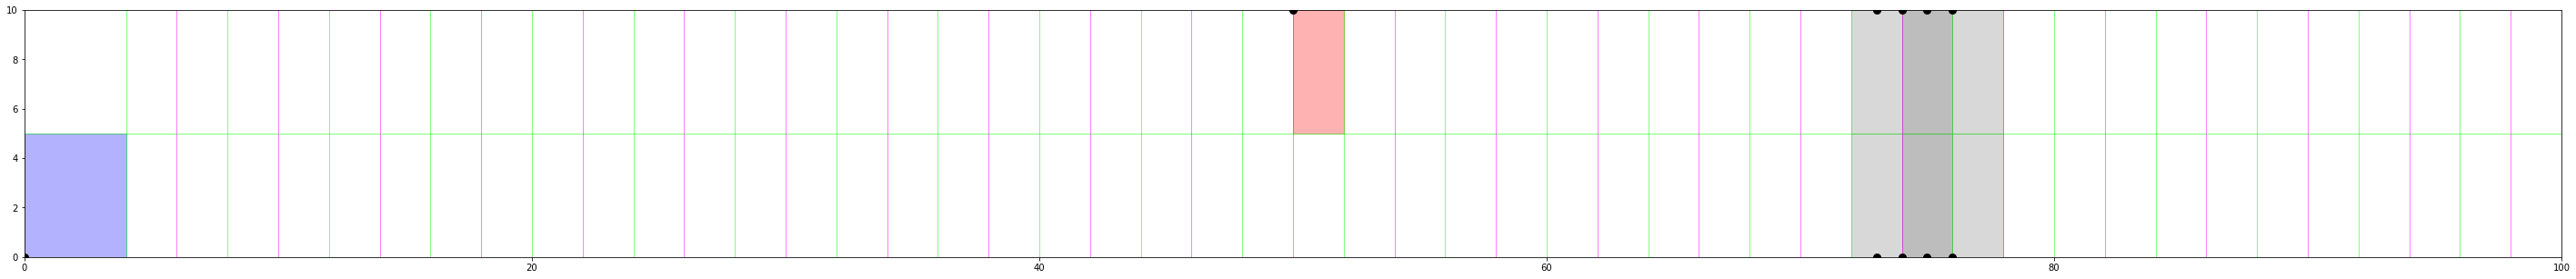

In [33]:
ax = plt.figure(figsize=(road_length*0.5, road_width * 0.5)).gca()
colors = distinctipy.get_colors(ped._tg.ntilings)

plot_tiling_group(ped._tg, ax=ax, linewidth=0.5, colors=colors)

states = [ped._loc, d] + road.getCrossingCoords()
state_colors = ['blue', 'red'] + ['grey']*len(road.getCrossingCoords())
for i, s in enumerate(states):
    c = state_colors[i]
    highlight_tiling_group(ped._tg, s=s, ax=ax, colors=[c], op = 'intersection') 
    plot_state(s, ax=ax, color='k')

## Run MC updates and plot resulting value function

In [74]:
n_updates = 1000
for i in range(n_updates):
	ped.mc_update_of_internal_model()

# Average over actions
w_av = ped.internal_model.w.mean(axis = 1)
N_av = ped.internal_model.N.mean(axis = 1)

In [79]:
# Loop through the nodes of the MDP - these are all the states
features = list(ped.internal_model.dict_id_feature.values())
unpacked = unpack_feature_values(features, w = w_av, N = N_av)

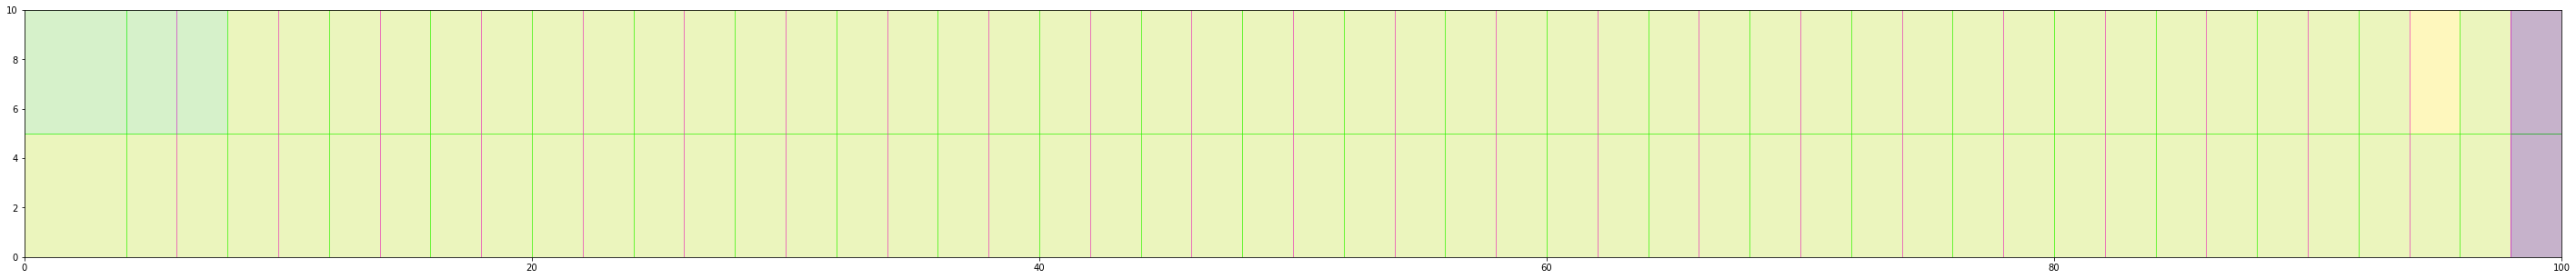

In [93]:
# Plot value function
ax = plot_feature_values(ped._tg, features, unpacked['values'], (road_length*0.5, road_width * 0.5), nbins = 10, cmap = 'viridis', alpha = 0.5, op = 'intersection')

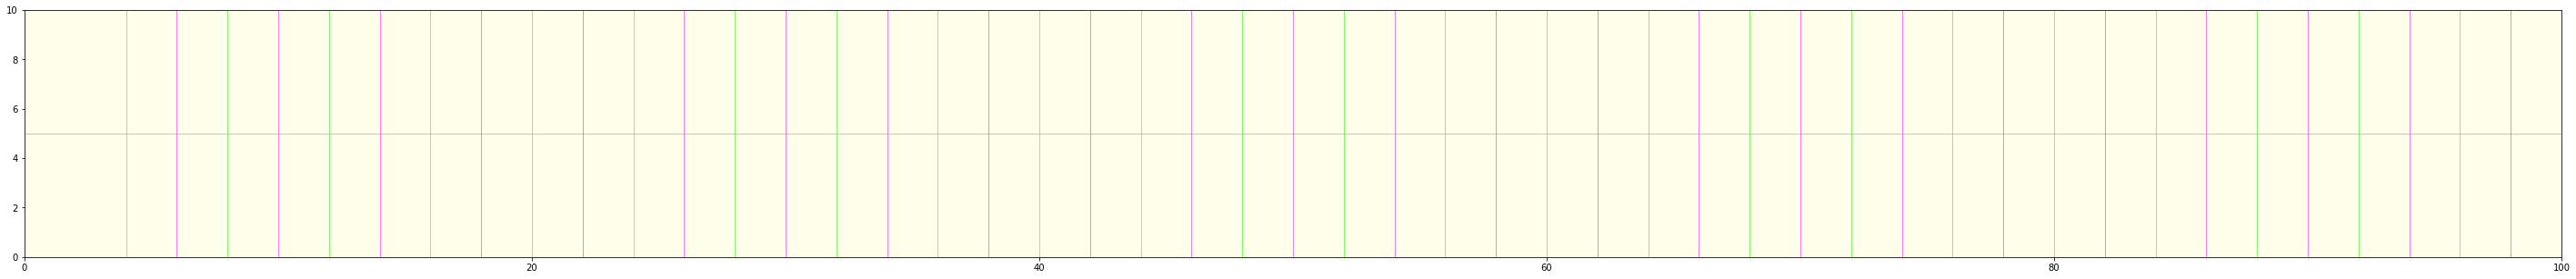

In [94]:
# Plot n visits
ax = plot_feature_values(ped._tg, features, unpacked['n_visits'], (road_length*0.5, road_width * 0.5), nbins = 10, cmap = 'magma', alpha = 0.5, op = 'intersection')

In [27]:
# Why is N not showing expected values

# trial state
d_f = ped._tg.feature(d)

In [28]:
d_f

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [43]:
np.matmul(d_f, N_av)

902.0

In [60]:
n_hist

array([ 1, 24, 24, 24, 19,  5,  0,  0,  0,  1], dtype=int64)

In [61]:
n_bin_edges

array([  38.75,  226.35,  413.95,  601.55,  789.15,  976.75, 1164.35,
       1351.95, 1539.55, 1727.15, 1914.75])